In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [77]:
chemin_fichier_excel = "C:\\Users\\jean-\\Desktop\\Cours ENSAE\\statapp\\SX5Edec2021.xlsx"

df = pd.read_excel(chemin_fichier_excel, parse_dates=['Dates'])
df = df.rename(columns={'SX5E Index': 'Cours'})

In [78]:
#rescaling de la vol avec les rendements rescalés en faisant juste rdt t/vol t-1


#on rajoute une ligne avec les rendements journaliers Xt
df['Rendements journaliers Xt en %']=df['Cours'].pct_change()*10
#on supprime la 1e ligne car le rdt journalier vaut NaN
#df = df.iloc[1:]
#df = df.reset_index(drop=True)


#on calcule les rendements rescalés: rdt t/vol t-1
returns=df['Rendements journaliers Xt en %'].to_numpy()
vol60 = np.empty(len(returns))
rescaledreturns1 = np.empty(len(returns))

for t in range(0,59):
    vol60[t]=1

for t in range(60, len(rescaledreturns1)):
    returnmoyen60 = np.mean(returns[t-60:t]) 
    vol60[t]=np.sqrt(np.mean((returns[t-60:t]-returnmoyen60)**2)) 
    rescaledreturns1[t]=returns[t]/vol60[t-1]
    #rescaledreturns1[t]=returns[t]*0.1/vol60[t-1]  -> tester en enlevant le *100 sur les rendements et en remettant le *0.1

    
#puis on calcule la vol rescalée à partir de nos rendements rescalés  

rescaledvol1 = np.empty(len(returns))

for t in range(0,59):
    rescaledvol1[t]=np.nan

for t in range(60, len(returns)):
    rescaledreturnsmoyen60 = np.mean(rescaledreturns1[t-60:t]) 
    rescaledvol1[t]=np.sqrt(np.mean((rescaledreturns1[t-60:t]-rescaledreturnsmoyen60)**2)) 
    

#on ajoute au dataframe la colonne vol rescalée et rendements rescalés 
df['vol rescalée 60 jours 1e methode']=rescaledvol1*0.1
df['rendements rescalés 1e méthode']=rescaledreturns1





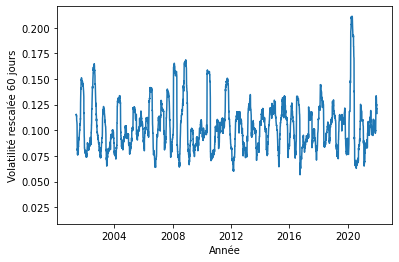

<Figure size 432x288 with 0 Axes>

In [79]:
# On trace la volatilité rescalée 60 jours sans prendre en compte les 60 premiers jours car on l'a fixée arbitrairement à 1
plt.plot(df['Dates'].iloc[61:], df['vol rescalée 60 jours 1e methode'].iloc[61:], label='Volatilité rescalée 60 jours 1e méthode')
plt.xlabel('Année')
plt.ylabel('Volatilité rescalée 60 jours')
plt.title('')
plt.show()

chemin_sauvegarde = 'C:\\Users\\jean-\Desktop\\Cours ENSAE\\statapp\\graphiques statapp\\volrescalée.png'
plt.savefig(chemin_sauvegarde, dpi=300)

#il faut peut être diviser la vol par 10 pour avoir les mêmes ordres de grandeur que sans tweaker les données 
# c'est deja mieux qu'avant sans tweaker les données mais il y a quand même une certaine amplitude -> c'est normal ? 

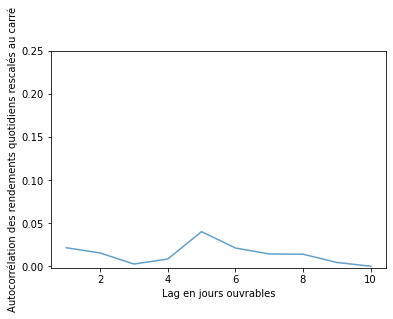

In [80]:
# on trace l'autocorrélation des rendements au carré après le rescaling

max_lag = 10  
autocorr_squared1 = [(df['rendements rescalés 1e méthode'].autocorr(lag=i)**2)*100 for i in range(1, max_lag + 1)]


plt.plot(range(1, max_lag + 1), autocorr_squared1, marker='', linestyle='-', color='#1f77b4', alpha=0.7)

plt.yticks(np.arange(0, 0.3, step=0.05))

plt.title('')
plt.xlabel('Lag en jours ouvrables')
plt.ylabel('Autocorrélation des rendements quotidiens rescalés au carré')
#plt.grid(False)

#chemin_sauvegarde = 'C:\\Users\\jean-\\Desktop\\Cours ENSAE\\statapp\\graphiques statapp\\autocorrel.png'
#plt.savefig(chemin_sauvegarde, dpi=300)

plt.show()

# c'est moins pire que sans tweaker les données mais c'est pas constant non plus. Si on zoome on voit que c'est pas constant du tout

0.01544279378882756 1.0764362824432205


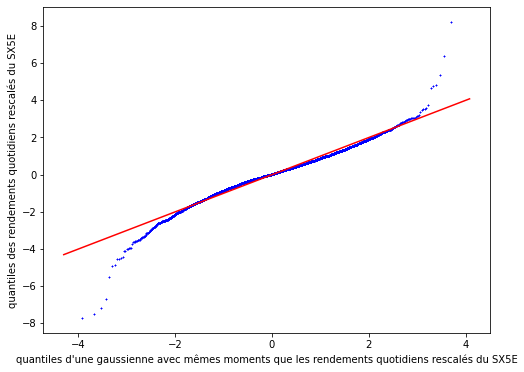

In [81]:
#on trace le qq plot après rescaling 

#on calcule les moments 
from scipy.stats import probplot
murescalé = np.mean(df['rendements rescalés 1e méthode'])
sigmarescalé = np.std(df['rendements rescalés 1e méthode'])
print(murescalé,sigmarescalé)
fig, ax = plt.subplots(figsize=(8, 6))
probplot(df['rendements rescalés 1e méthode'], dist='norm', sparams=(murescalé, sigmarescalé), plot=ax)
plt.plot(plt.xlim(),plt.xlim(),color='red', label='y=x')
plt.xlabel("quantiles d'une gaussienne avec mêmes moments que les rendements quotidiens rescalés du SX5E")
plt.ylabel("quantiles des rendements quotidiens rescalés du SX5E")
plt.title('')

ax.get_lines()[0].set_marker('+')
ax.get_lines()[0].set_markersize(2)
ax.get_lines()[0].set_markerfacecolor('blue')
ax.get_lines()[0].set_markeredgecolor('blue')

chemin_sauvegarde = 'C:\\Users\\jean-\\Desktop\\Cours ENSAE\\statapp\\graphiques statapp\\quantiles.png'
#plt.savefig(chemin_sauvegarde, dpi=300)

#ça fit tjrs aussi mal sur la queue mais au moins ça fit mieux sur [-2.5;2.5]
#au vu de la valeur de la moyenne empirique et de la variance empirique, ça fit plus ou moins bien une N(0,1)

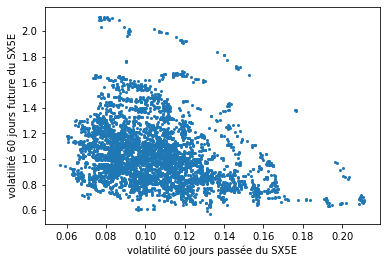

In [82]:
#puis on trace le graphe de vol 60d passés contre vol 60d future
#pour ça il faut aussi tracer la vol future 

rescaledvolfuture = np.empty(len(returns))

for t in range(len(returns)-59,len(returns)):
    rescaledvol1[t]=1

for t in range(0, len(returns)-60):
    rescaledreturnsmoyenfutur60 = np.mean(rescaledreturns1[t:t+60]) 
    rescaledvolfuture[t]=np.sqrt(np.mean((rescaledreturns1[t:t+60]-rescaledreturnsmoyenfutur60)**2)) 
    

df['vol rescalée 60 jours future']=rescaledvolfuture

plt.scatter(df['vol rescalée 60 jours 1e methode'],df['vol rescalée 60 jours future'],s=4,marker='o')
plt.xlabel("volatilité 60 jours passée du SX5E")
plt.ylabel("volatilité 60 jours future du SX5E")
plt.title('')
chemin_sauvegarde = 'C:\\Users\\jean-\\Desktop\\Cours ENSAE\\statapp\\graphiques statapp\\volfuturesurpassée.png'
plt.savefig(chemin_sauvegarde, dpi=300)

#revoir les échelles en abscisse et en ordonnée 

In [83]:
import statsmodels.api as sm

x=sm.add_constant(df['vol rescalée 60 jours 1e methode'].iloc[122:].iloc[:-60].to_numpy())
y=df['vol rescalée 60 jours future'].iloc[122:].iloc[:-60].to_numpy()

modele = sm.OLS(y,x)

results=modele.fit()

print(results.summary())

#on voit que la p value est tjrs significative 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     565.7
Date:                Tue, 23 Jan 2024   Prob (F-statistic):          8.03e-119
Time:                        15:24:19   Log-Likelihood:                 334.77
No. Observations:                5227   AIC:                            -665.5
Df Residuals:                    5225   BIC:                            -652.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3669      0.014     97.568      0.0

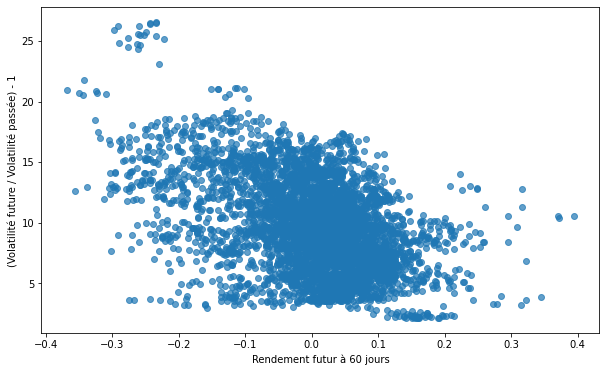

In [84]:
df['performance_future'] = df['Cours'].shift(-60) / df['Cours'] - 1

df['ratio_volatilite'] = (df['vol rescalée 60 jours future'] / df['vol rescalée 60 jours 1e methode']) - 1

# Création du graphique en nuage de points
plt.figure(figsize=(10, 6))
plt.scatter(df['performance_future'], df['ratio_volatilite'], alpha=0.7)

# Ajout de labels et titre
plt.title('')
plt.xlabel('Rendement futur à 60 jours')
plt.ylabel('(Volatilité future / Volatilité passée) - 1')

chemin_sauvegarde = 'C:\\Users\\jean-\\Desktop\\Cours ENSAE\\statapp\\graphiques statapp\\volsmile.png'
plt.savefig(chemin_sauvegarde, dpi=300)

# Affichage du graphique
plt.show()

In [85]:
print(np.corrcoef(df['vol rescalée 60 jours 1e methode'].iloc[122:].iloc[:-60],y))   
##maintenant coeff de correlation inverse entre vol future et vol passée 

[[ 1.         -0.31256593]
 [-0.31256593  1.        ]]
